In [2]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd
import csv
import numpy as np

from tensorflow.keras.applications.inception_v3 import InceptionV3

tf.config.list_physical_devices('GPU') 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
DATAPATH = os.path.abspath('../../data/')

1 Physical GPUs, 1 Logical GPUs


In [3]:
def get_data(filename):
    images = []
    labels = []
    with open(filename) as training_file:
        csv_reader = csv.reader(training_file)
        for i, row in enumerate(csv_reader):
            if i == 0:
                continue
            label = row[0]
            
            image = row[1:785]
            image = np.reshape(image, (28,28))
            
            images.append(image)
            labels.append(label)
      # Your code starts here
      # Your code ends here
    images = np.array(images).astype(float)
    labels = np.array(labels).astype(float)
    return images, labels

path_sign_mnist_train = os.path.join(DATAPATH, "sign_mnist_train.csv")
path_sign_mnist_test = os.path.join(DATAPATH, "sign_mnist_test.csv")
training_images, training_labels = get_data(path_sign_mnist_train)
testing_images, testing_labels = get_data(path_sign_mnist_test)

print(training_images.shape)
print(training_labels.shape)
print(testing_images.shape)
print(testing_labels.shape)

(27455, 28, 28)
(27455,)
(7172, 28, 28)
(7172,)


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

training_images = np.reshape(training_images, (-1, 28, 28 ,1))
testing_images = np.reshape(testing_images, (-1, 28, 28 ,1))

train_datagen = ImageDataGenerator(
      rescale = 1./255,
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
#       horizontal_flip=True,
      fill_mode='nearest')

train_datagen.fit(training_images)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen.fit(testing_images)

BS = 16

training_labels = tf.keras.utils.to_categorical(training_labels, num_classes = 25)
testing_labels = tf.keras.utils.to_categorical(testing_labels, num_classes = 25)

train_generator = train_datagen.flow(training_images, training_labels, batch_size=BS)
validation_generator = validation_datagen.flow(testing_images, testing_labels, batch_size=BS)
    
print(training_images.shape)
print(testing_images.shape)


(27455, 28, 28, 1)
(7172, 28, 28, 1)


In [5]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(25, activation='softmax')
])

 
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit_generator(train_generator, 
                              epochs=3, 
                              steps_per_epoch=len(training_images)//BS, 
                              validation_data = validation_generator, 
                              verbose = 1, 
                              validation_steps=len(testing_images)//BS)

model.evaluate(testing_images/255., testing_labels, verbose=0)

C:\Users\Khachatur\Miniconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
1715/1715 [==============================] - 14s 6ms/step - loss: 2.5262 - accuracy: 0.2412 - val_loss: 0.6612 - val_accuracy: 0.7553
Epoch 2/3
1715/1715 [==============================] - 11s 6ms/step - loss: 0.9931 - accuracy: 0.6782 - val_loss: 0.3539 - val_accuracy: 0.8888
Epoch 3/3
1715/1715 [==============================] - 11s 6ms/step - loss: 0.6712 - accuracy: 0.7795 - val_loss: 0.2046 - val_accuracy: 0.9220


[0.2045125514268875, 0.9220579862594604]

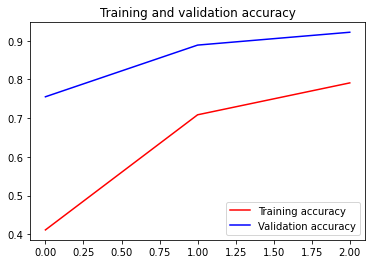

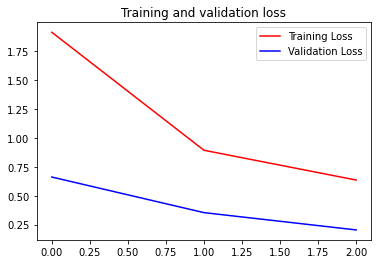

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()